# "Progressiveness" metric
Based on document distance between treaties per year
sdfksjbdñkajsbdvkjsadv´lkadfnb´ldjnfbkssk

+ dsafbadfb


## Imports

In [1]:
# Must be cleaned
import re
import os
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import random
from sklearn.decomposition import PCA
import nltk
from nltk.corpus import stopwords # Import the stop word list
import gensim
import gensim.downloader as api
from gensim.parsing.preprocessing import strip_short
from pyemd import emd
import numpy as np

## Preprocessing

In [2]:
#Function for preprocessing text
def txt_cleaner(text):
    meaningful_words = []
    text = text.lower() #make all lowercase
    #text = strip_short(text, minsize=4) #remove short words
    tokens = word_tokenize(text) # returns list of words
    tokens = [w for w in tokens if w.isalpha()] #remove punctuation, also numbers
    stops = set(stopwords.words("english"))
    tokens = [w for w in tokens if not w in stops] # remove stop words
    for item in tokens: #filter short and long words
        if len(item) >= 3 and len(item) < 30:
            meaningful_words.append(item)
    return meaningful_words

In [3]:
# Search directory
directory_in_str = "../xml/"
directory = os.fsencode(directory_in_str)

In [4]:
# Generate base data frame
# The 'text' column will contain list with sublists, where every sublist will contain the tokenized text of every chapter
print("Preprocessing files to dataframe..")
text_df = pd.DataFrame(columns=['filename', 'id','type', 'year_signed', 'month', 'day', 'text'])
for n,file in enumerate(os.listdir(directory)):
    new_row = []
    filename = os.fsdecode(file)
    if filename.endswith('.XML') or filename.endswith('.xml'):
        new_row.append(filename)
        tree = ET.parse(directory_in_str + filename)
        root = tree.getroot()
        meta = root[0]
        body = root[1]
        text_list = []
        if meta.find('language').text == 'en': 
            new_row.append(meta.find('treaty_identifier').text)
            new_row.append(meta.find('type').text)
            new_row.append(int(meta.find('date_signed').text.split('-')[0]))
            new_row.append(int(meta.find('date_signed').text.split('-')[1]))
            new_row.append(int(meta.find('date_signed').text.split('-')[2]))
            for chapter in body: 
                text = ''
                ch_text = []
                for item in chapter.iter():
                    text += item.text
                ch_text = txt_cleaner(text)
                text_list.append(ch_text)
            new_row.append(text_list)
            text_df.loc[n] = new_row
text_df.head(5)

Preprocessing files to dataframe..


,filename,id,type,year_signed,month,day,text
0,pta_218.xml,218,Free Trade Agreement,1975,4,28,"[[kingdom, denmark, ireland, united, kingdom, ..."
1,pta_230.xml,230,Free Trade Agreement,1972,7,22,"[[european, economic, community, one, part, po..."
2,pta_224.xml,224,Free Trade Agreement,1977,5,3,"[[object, agreement, community, lebanon, promo..."
3,pta_378.xml,378,Partial Scope Agreement,2007,7,30,"[[preferential, trade, agreement, republic, ma..."
4,pta_344.xml,344,Free Trade Agreement,2009,7,14,"[[free, trade, agreement, republic, chile, rep..."


In [33]:
# Convert 'date_signed' column to datetime object
#text_df['date_signed'] = pd.to_datetime(text_df.date_signed)

# Sort items by date
text_df.sort_values(by='year_signed', inplace=True)

# Set 'id' as index (verify integrity in case of duplicates)
text_df = text_df.set_index(['id'],verify_integrity=True)
text_df.head(5)

,filename,type,year_signed,month,day,text
id,,,,,,
310,pta_310.xml,Customs Union,1948,12,6,"[[state, informationof, contracting, parties, ..."
254,pta_254.xml,Free Trade Agreement,1951,3,9,"[[treaty, republics, nicaragua, salvador, gove..."
110,pta_110.xml,Customs Union & Economic Integration Agreement,1957,3,25,"[[consolidated, version, treaty, european, uni..."
188,pta_188.xml,Free Trade Agreement,1958,6,10,"[[text, articles, xxviiiof, multilateral, trea..."
255,pta_255.xml,Free Trade Agreement,1959,6,23,"[[central, african, republic, republic, congo,..."


In [ ]:
#Save resulting dataframe to csv
out_dir = "saved_csv/"
csv_out = "text_df.csv"
csv_data.to_csv(out_dir + csv_out, index = True, header=True)\n",

## Selection
Here we define the selection of treaties we want to compare against each other

In [34]:
# Get list of unique years
l = text_df['year_signed'].unique()

# List of dataframes to iterate over
list_df = []

# Separate treaties from 1948 - 1988 by decade. From 1991 to 2016 by year
# There are 28 treaties in the slice, we will divide the 28 treaties in 4 groups of 7
slices =[[0,7],[7,14],[14,21],[21,28]]

# Append year slices to list of dataframes
for item in slices:
    list_df.append(text_df[text_df.year_signed.isin(l[item[0]:item[1]])])
for item in l[29:]:
    list_df.append(text_df[text_df.year_signed.isin([item])])

## Distance calculations
+ Reduce amount of words(by substracting the most common words)
+ Convert text from list of list of words to list of words

In [21]:
# Import pretrained model
model = gensim.models.KeyedVectors.load_word2vec_format('../../../GoogleNews-vectors-negative300.bin.gz', binary=True)
# Notice this vectors are already normalized

In [ ]:
dist_df = [] #this is where we will store all our distance matrices
for dfx in list_df:
    print(f'Processing from: {dfx.year_signed.max()} to {dfx.year_signed.min()}')
    labels = list(dfx.index.values) #labels for dataframe
    labels = ['id'] + labels #append 'id'
    distances = []
    for x in dfx.iterrows():
        print(f'Row: {x[0]}')
        dist_tmp = [] #temporal list for current row
        t1 = [words for sublist in x[1][5] for words in sublist]
        dist_tmp.append(x[0]) #append index
        for y in dfx.iterrows():
            t2 = [words for sublist in y[1][5] for words in sublist]
            d = model.wmdistance(t1, t2)
            dist_tmp.append(d)
        distances.append(dist_tmp) #once done with row, append to total distances
    df = pd.DataFrame.from_records(distances, columns=labels, index=['id']) #once all distances for current df are coll
    dist_df.append(df)

Processing from: 1961 to 1948
Row: 310
Row: 254
Row: 110
Row: 188
Row: 255
Row: 138
Row: 275
Row: 266
Row: 175
Row: 219
Processing from: 1970 to 1962
Row: 164
Row: 242
Row: 316
Row: 172
Row: 274
Row: 174
Row: 187
Row: 136
Row: 173
Row: 227
Row: 240
Row: 135
Row: 317
Row: 241
Row: 222
Row: 134
Row: 237
Row: 226
Processing from: 1979 to 1971
Row: 133
Row: 131
Row: 130
Row: 238
Row: 207
Row: 230
Row: 213
Row: 210
Row: 128
Row: 129
Row: 217
Row: 243
Row: 127
Row: 318
Row: 218
Row: 126
Row: 206
Row: 125
Row: 224
Row: 214


In [72]:
#Save resulting dataframe to csv
#out_dir = "saved_csv/googlenews/"
#csv_out = "dist_df_2_.csv"
#dist_df[2].to_csv(out_dir + csv_out, index = True, header=True)

## Graphs

Force directed
+ Based on this: https://stackoverflow.com/questions/13513455/drawing-a-graph-or-a-network-from-a-distance-matrix

In [53]:
import networkx as nx
import string
import pygraphviz

In [61]:
# Visualization directory output
out_dir_vis = "vis/googlenews/"
png_out = "out_2.png"

In [70]:
dt = [('len', float)]
A = dist_df[2].values

A = A.view(dt)

G = nx.from_numpy_matrix(A)
G = nx.relabel_nodes(G, dict(zip(range(len(G.nodes())),list(dist_df[1].columns.values))))    

G = nx.drawing.nx_agraph.to_agraph(G)

G.node_attr.update(fillcolor="transparent", shape="circle", style="filled", size = 0.1)
G.edge_attr.update(color="transparent", width="2.0")

G.draw(out_dir_vis + png_out, format='png', prog='neato')

In [69]:
dist_df[2].drop(['319'], axis=1, inplace=True)

Voronoi
+ Use points from nodes to generate voronoi

Ordered similarity matrix, heat map

## old code

In [334]:
# For every treaty in DF, calculate distance between first chapter and all the other chapters in the same treaty
t_d = []
for item in text_df.iterrows():
    print(item[1][0])
    d = []
    for x,n in enumerate(range(0,len(item[1][4]))):
        t1 = item[1][4][0]
        t2 = item[1][4][n]
        distance = model.wmdistance(t1, t2)
        d.append(distance)
    t_d.append([d])

pta_218.xml
pta_230.xml
pta_224.xml
pta_378.xml
pta_344.xml
pta_422.xml
pta_436.xml
pta_350.xml
pta_387.xml
pta_393.xml
pta_146.xml
pta_152.xml
pta_185.xml
pta_191.xml
pta_36.xml
pta_190.xml
pta_37.xml
pta_23.xml
pta_184.xml
pta_153.xml
pta_147.xml
pta_392.xml


KeyboardInterrupt: 

In [260]:
# Make embedding with all the text in the treaties
model = gensim.models.Word2Vec(text_df['text'])

TypeError: unhashable type: 'list'

In [9]:
# PCA dimensionality reduction
X = model[model.wv.vocab]
pca = PCA(n_components=2)
resultX = pca.fit_transform(X)

/Users/estebanserranorodriguez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [10]:
resultX[:, 0]#of all items in array, return the first sub-item

array([-2.7311416 , -0.92988163, -0.59957564, ...,  0.31906852,
        0.31739098,  0.580022  ], dtype=float32)

In [12]:
plt.rcParams['figure.figsize'] = (12.0, 12.0) #set size of figure

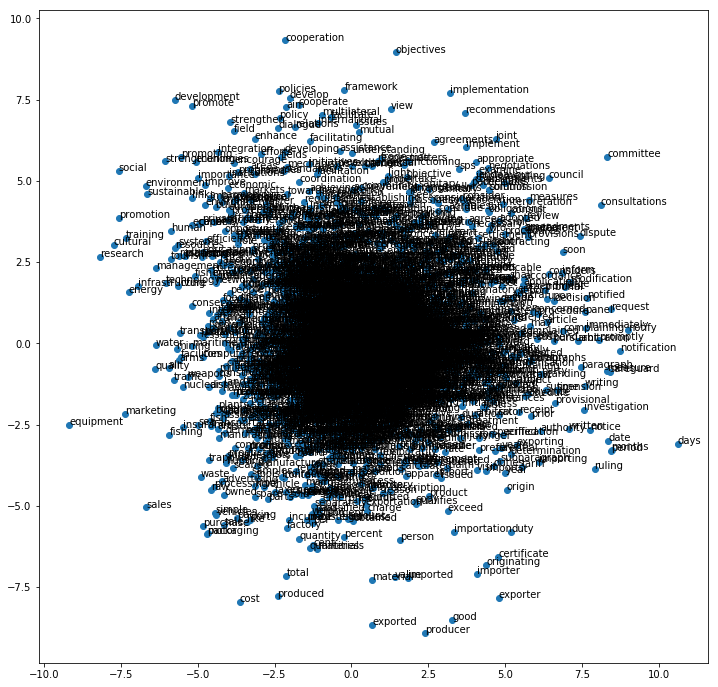

In [13]:
plt.scatter(resultX[:, 0], resultX[:, 1])
words = list(model.wv.vocab)
#samples  = random.sample(words,10)
for i, word in enumerate(words):
	plt.annotate(word, xy=(resultX[i, 0], resultX[i, 1]))

In [15]:
#Compute similarity of word
model.wv.most_similar(positive="car")

[('railroad', 0.9335185289382935),
 ('locomotive', 0.907139778137207),
 ('trailer', 0.8136420249938965),
 ('două', 0.7734525203704834),
 ('mii', 0.766512930393219),
 ('dne', 0.7662320733070374),
 ('eiropas', 0.7637734413146973),
 ('luxemburgo', 0.7625185251235962),
 ('douăzeci', 0.7601284980773926),
 ('novecentos', 0.759929358959198)]

Pending:
    Document similarity
    Plot embeddings grouped by type of treaty
    how to show only the most important words in word embedding?
    try with pretrained models
    some words are not usable 